<a href="https://colab.research.google.com/github/digitalpraveen/ML-PROJECTS/blob/main/quora_question_pair_similarity/quora_question_pair_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


In [ ]:
! unzip "/kaggle/input/quora-question-pairs/train.csv.zip"
! unzip "/kaggle/input/quora-question-pairs/test.csv.zip"

Archive:  /kaggle/input/quora-question-pairs/train.csv.zip
  inflating: train.csv               
Archive:  /kaggle/input/quora-question-pairs/test.csv.zip
  inflating: test.csv                


# Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
%matplotlib inline

! pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords

!pip3 install distance
import distance
from nltk.stem import PorterStemmer
! pip3 install bs4
from bs4 import BeautifulSoup

     |████████████████████████████████| 180 kB 4.4 MB/s eta 0:00:01
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16260 sha256=94797db9fb67caf405fe0a44f6f98b1570f4293f2d9612b77692985ebce25a97
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance
     |████████████████████████████████| 115 kB 4.4 MB/s eta 0:00:01
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=5b52080d2c4e1bdc3f98e9e88b3733f150be76c2589d9aec0722200bb9e2861e
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


# 3.1 Reading and Basic EDA

In [ ]:
df=pd.read_csv("train.csv")
print("number of data points",df.shape[0])

number of data points 404290


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# 3.2 Distribution of data points among output classes

<AxesSubplot:xlabel='is_duplicate'>

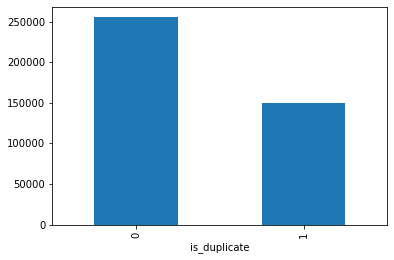

In [ ]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [ ]:
print("total number of question pairs for training {}".format(len(df)))

total number of question pairs for training 404290


In [ ]:
print("question pairs are not similar {}".format(100-round(df['is_duplicate']).mean()*100,2))
print("question pairs are similar {}".format(round(df['is_duplicate']).mean()*100))

question pairs are not similar 63.0802146973707
question pairs are similar 36.9197853026293


# 3.2.1  Number of unique questions

In [ ]:
qids=pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)

print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



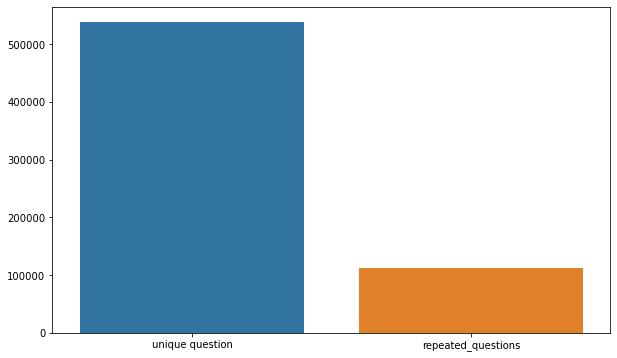

In [ ]:
x=["unique question","repeated_questions"]
y=[unique_qs,qs_morethan_onetime]

plt.figure(figsize=(10,6))
sns.barplot(x,y)
plt.show()

# check for duplicate

In [ ]:
pair_duplicate=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("no of duplicate questions",(pair_duplicate).shape[0]-df.shape[0])

no of duplicate questions 0


# No of occurance of each questions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Maximum number of times a single question is repeated: 157



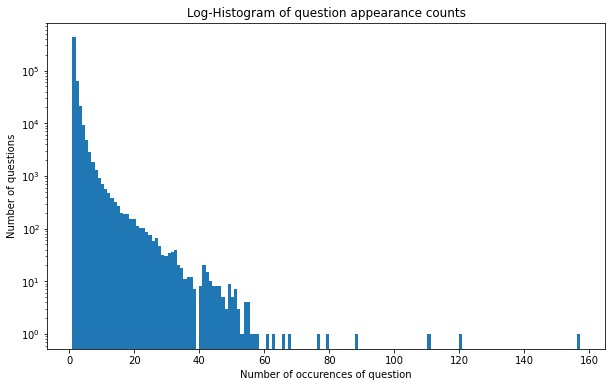

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

# Checking for null values

In [ ]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [ ]:
df=df.fillna("")
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic Feature Extraction


    freq_qid1 = Frequency of qid1's
    freq_qid2 = Frequency of qid2's
    q1len = Length of q1
    q2len = Length of q2
    q1_n_words = Number of words in Question 1
    q2_n_words = Number of words in Question 2
    word_Common = (Number of common unique words in Question 1 and Question 2)
    word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
    word_share = (word_common)/(word_Total)
    freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
    freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2


In [ ]:
if os.path.isfile("./df_fe_without_preprocessing_train.csv"):
    df=pd.read_csv("./df_fe_without_preprocessing_train.csv")
    df.head()
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalised_word_common(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0*len(w1 & w2)
    df['word_common']=df.apply(normalised_word_common,axis=1)
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)
    
df.head()
    
    
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


**Analysis of extraxted feature **

In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


# Word share

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



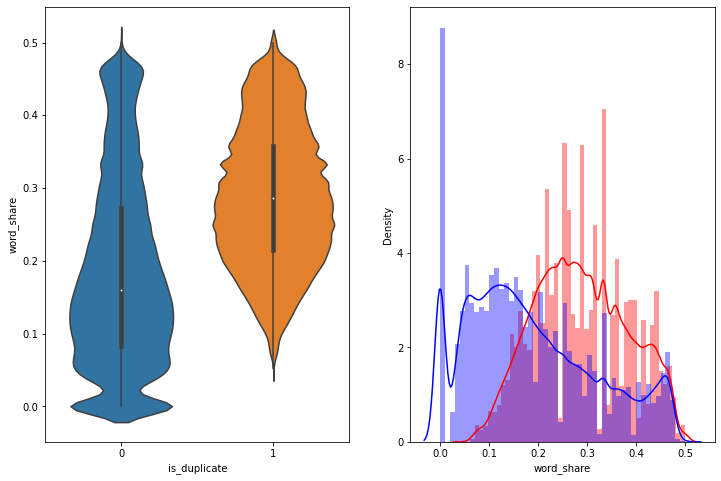

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )

plt.show()


    The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
    The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)



Feature: word_Common 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



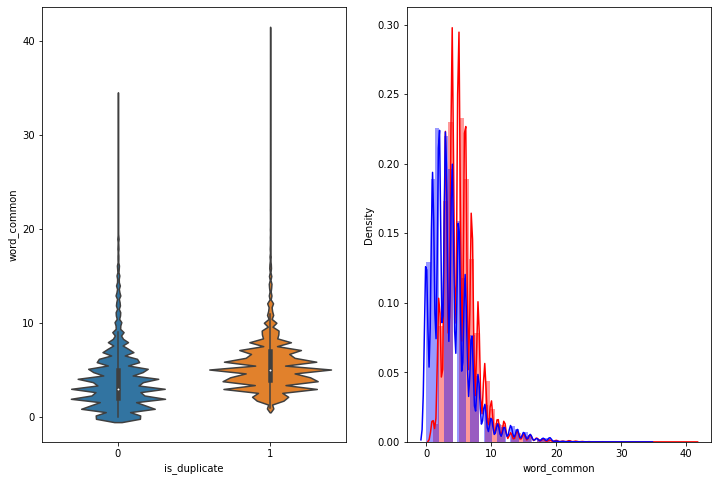

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping 

# EDA :Advanced Feature extraction

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import re
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud,STOPWORDS
from PIL import Image

In [ ]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


# Preprocessing of Text

Preprocessing:

    Removing html tags
    Removing Punctuations
    Performing stemming
    Removing Stopwords
    Expanding contractions etc.


In [ ]:
SAFE_DIV=0.0001

STOP_WORDS=stopwords.words('english')

def preprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000", r"lm", x)
    x = re.sub(r"([0-9]+)000", r"lk", x)
    
    
    porter=PorterStemmer()
    pattern=re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x
    
    

Definition:

    Token: You get a token by splitting sentence a space
    Stop_Word : stop words as per NLTK.
    Word : A token that is not a stop_word

Features:

    cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


    cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


    csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


    csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


    ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
    ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


    ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
    ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


    last_word_eq : Check if First word of both questions is equal or not
    last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


    first_word_eq : Check if First word of both questions is equal or not
    first_word_eq = int(q1_tokens[0] == q2_tokens[0])


    abs_len_diff : Abs. length difference
    abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


    mean_len : Average Token Length of both Questions
    mean_len = (len(q1_tokens) + len(q2_tokens))/2


    fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


    fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


    token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
    longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



In [ ]:
def get_token_features(q1,q2):
    token_features=[0.0]*10
    
    
    q1_tokens=q1.split()
    q2_tokens=q2.split()
    
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features
    
    q1_words=set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words=set([word for word in q2_tokens if word not in STOP_WORDS])
    
    q1_stops=set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops=set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count=len(q1_words.intersection(q2_words))
    
    common_stop_count=len(q1_stops.intersection(q2_stops))
    
    common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0]=common_word_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[1]=common_word_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[2]=common_stop_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[3]=common_stop_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[4]=common_token_count/(min(len(q1_words),len(q2_words))+SAFE_DIV)
    token_features[5]=common_token_count/(max(len(q1_words),len(q2_words))+SAFE_DIV)
    
    
    token_features[6]=int(q1_tokens[-1]==q2_tokens[-1])
    token_features[7]=int(q1_tokens[0]==q2_tokens[0])
    
    
    token_features[9]=(len(q1_tokens)+len(q2_tokens))/2
    
    return token_features



def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
    
def extract_features(df):
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    token_features=df.apply(lambda x:get_token_features(x['question1'],x['question2']),axis=1)
    
    df["cwc_min"]       = list(map(lambda x:x[0],token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df
    


    
    
    
    

In [ ]:

if os.path.isfile("./nlp_features_train.csv"):
    df=pd.read_csv("./nlp_features_train.csv",encoding='latin-1')
    df.fillna("")
else:
    print("Extracting features for train:")
    df = pd.read_csv("./train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)
    

Extracting features for train:


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,1.199976,0.999983,...,1.833303,0.0,1.0,0.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.599988,0.299997,...,0.699993,0.0,1.0,0.0,12.5,86,63,66,75,0.596154


# Analysis of extracteed features

In [ ]:
df_duplicate=df[df['is_duplicate']==1]
dfp_nonduplicate=df[df['is_duplicate']==0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
from os import path

d = path.dirname('./')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16108546
Total number of words in non duplicate pair questions : 33192304


Word Cloud for Duplicate Question pairs


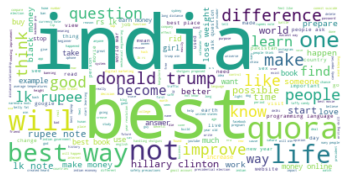

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


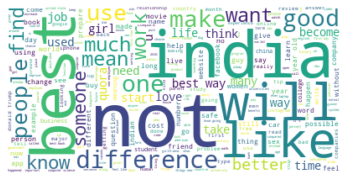

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

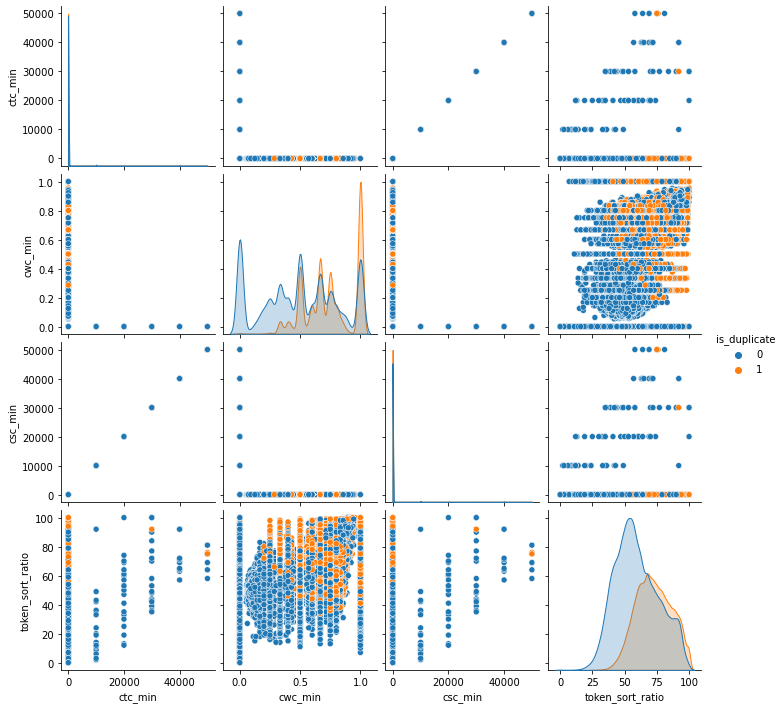

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

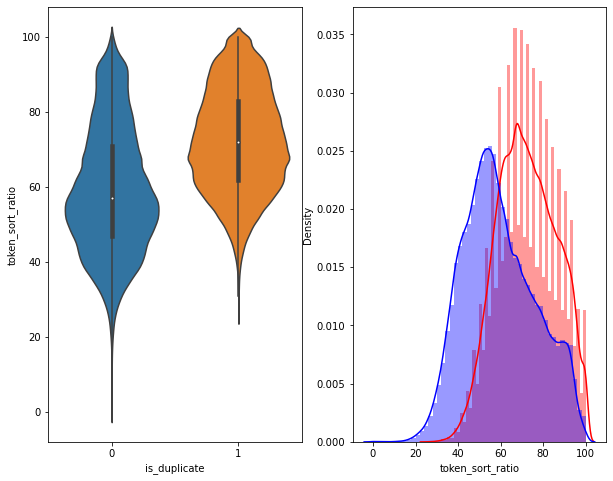

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

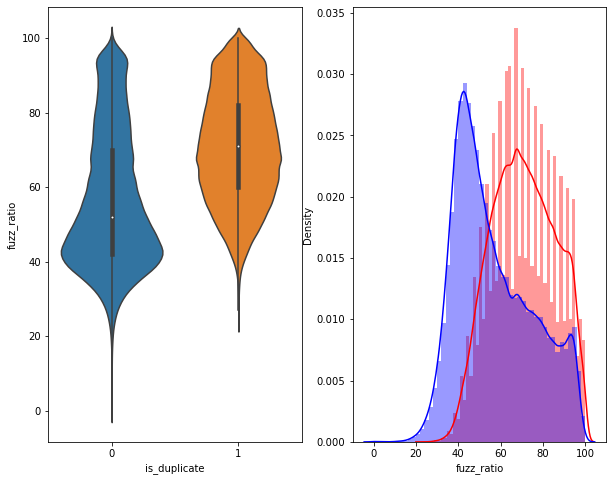

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

# Visualization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled=df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.017s...
[t-SNE] Computed neighbors for 5000 samples in 0.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.081942
[t-SNE] Computed conditional probabilities in 0.332s
[t-SNE] Iteration 50: error = 80.4257965, gradient norm = 0.0417096 (50 iterations in 1.621s)
[t-SNE] Iteration 100: error = 69.7949829, gradient norm = 0.0093312 (50 iterations in 1.169s)
[t-SNE] Iteration 150: error = 68.1150131, gradient norm = 0.0067517 (50 iterations in 1.116s)
[t-SNE] Iteration 200: error = 67.2650986, gradient norm = 0.0040767 (50 iterations in 1.135s)
[t-SNE] Iteration 250: error = 66.7973404, gradient norm = 0.0038987

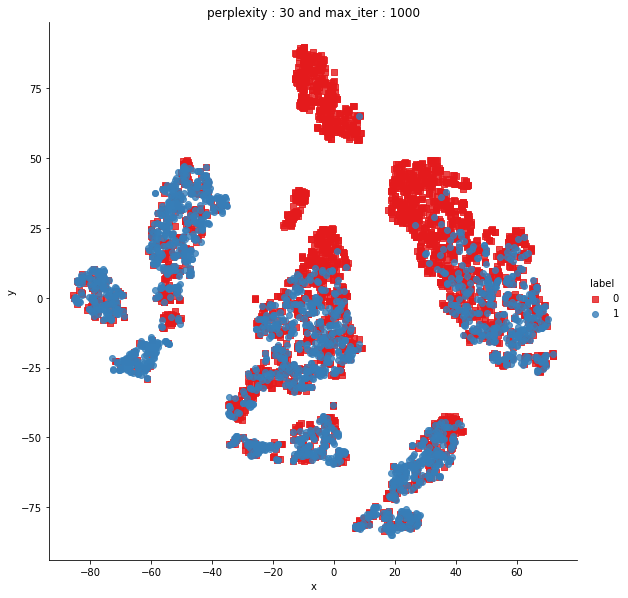

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.081942
[t-SNE] Computed conditional probabilities in 0.322s
[t-SNE] Iteration 50: error = 80.5098724, gradient norm = 0.0352349 (50 iterations in 5.794s)
[t-SNE] Iteration 100: error = 68.7963028, gradient norm = 0.0034941 (50 iterations in 2.690s)
[t-SNE] Iteration 150: error = 67.3692780, gradient norm = 0.0017269 (50 iterations in 2.477s)
[t-SNE] Iteration 200: error = 66.7728043, gradient norm = 0.0012665 (50 iterations in 2.583s)
[t-SNE] Iteration 250: error = 66.4451981, gradient norm = 0.0009198

In [ ]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# Featurizing text data with tfidf weighted word-vectors 

In [ ]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
from tqdm import tqdm

import spacy


In [ ]:
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
question=list(df['question1'])+list(df['question2'])

tfidf=TfidfVectorizer(lowercase=False)
tfidf.fit_transform(question)


word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 404290/404290 [1:06:42<00:00, 101.01it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:09:51<00:00, 96.46it/s] 


In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv")
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,1.199976,0.999983,2.199956,1.833303,0.0,1.0,0.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.599988,0.299997,1.399972,0.699993,0.0,1.0,0.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.333328,0.799984,0.666656,0.0,1.0,0.0,12.0,66,66,54,54,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.0,36,36,35,40,0.039216
4,4,0,0.399992,0.199998,0.399992,0.199998,0.799984,0.399996,0.0,1.0,0.0,10.0,67,47,46,56,0.175000


In [ ]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,78.682992,87.635912,77.898819,-61.473692,44.053226,18.525178,-28.609312,47.452460,-86.095610,58.907952,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,99.993008,55.174564,-2.049167,36.677249,85.412371,-45.989080,31.112590,76.453094,-74.456509,110.348369,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,62.709638,72.489519,10.889310,-45.772860,71.261772,-34.385969,-26.228285,18.224490,-113.496336,115.968702,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,35.006791,-40.413219,53.450493,-45.069038,37.137247,-21.992808,-28.184323,131.916699,41.891510,27.243861,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,135.425154,187.445625,143.612776,-111.735024,56.977977,-70.101866,-47.585533,59.575895,-56.992457,253.326808,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797


In [ ]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,69.938774,62.048677,65.471186,-65.080995,37.007811,11.953720,-44.908971,39.077935,-71.113359,64.970021,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,100.523184,60.707327,114.135677,-2.311834,28.477254,-0.705671,113.688085,117.816506,-93.662698,81.227491,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,28.122773,-0.262905,-8.952834,-14.151883,18.908912,40.142980,62.036967,60.638759,-79.254361,108.044290,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,22.605501,-22.139145,18.226516,-20.430915,22.291252,35.642941,-31.471534,61.818255,-40.677339,33.871990,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,1.158371,29.232888,66.428352,-43.949273,12.497666,6.992168,-57.236839,32.344526,-56.251407,48.231540,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

import sqlite3
from sqlalchemy import create_engine # database connection
import datetime as dt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier



from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
#Creating db file from csv
"""
if not os.path.isfile('./train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('./final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
 """

"\nif not os.path.isfile('./train.db'):\n    disk_engine = create_engine('sqlite:///train.db')\n    start = dt.datetime.now()\n    chunksize = 180000\n    j = 0\n    index_start = 1\n    for df in pd.read_csv('./final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','5

In [ ]:
"""
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
     create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))
"""

'\n#http://www.sqlitetutorial.net/sqlite-python/create-tables/\ndef create_connection(db_file):\n     create a database connection to the SQLite database\n        specified by db_file\n    :param db_file: database file\n    :return: Connection object or None\n    \n    try:\n        conn = sqlite3.connect(db_file)\n        return conn\n    except Error as e:\n        print(e)\n \n    return None\n\n\ndef checkTableExists(dbcon):\n    cursr = dbcon.cursor()\n    str = "select name from sqlite_master where type=\'table\'"\n    table_names = cursr.execute(str)\n    print("Tables in the databse:")\n    tables =table_names.fetchall() \n    print(tables[0][0])\n    return(len(tables))\n'

In [ ]:
"""
  #read_db = 'train.db'
#  conn_r = create_connection(read_db)
 # checkTableExists(conn_r)
conn_r.close()
"""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-54-edbcbc44ba89>, line 5)

In [ ]:
"""
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()
"""

In [ ]:
df=pd.read_csv("./final_features.csv")

In [ ]:
df.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,1.199976,0.999983,2.199956,1.833303,0.0,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,1,1,0,0.799984,0.399996,0.599988,0.299997,1.399972,0.699993,0.0,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,2,2,0,0.399992,0.333328,0.399992,0.333328,0.799984,0.666656,0.0,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,4,4,0,0.399992,0.199998,0.399992,0.199998,0.799984,0.399996,0.0,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [ ]:
# remove the first row 

y_true = df['is_duplicate']
df.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [ ]:
df.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.999980,0.833319,1.199976,0.999983,2.199956,1.833303,0.0,1.0,0.0,13.0,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,0.799984,0.399996,0.599988,0.299997,1.399972,0.699993,0.0,1.0,0.0,12.5,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,0.399992,0.333328,0.399992,0.333328,0.799984,0.666656,0.0,1.0,0.0,12.0,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,12.0,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,0.399992,0.199998,0.399992,0.199998,0.799984,0.399996,0.0,1.0,0.0,10.0,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [ ]:
-y_true = list(map(int, y_true.values))

#  Random train test split( 70:30) 

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 218)
Number of data points in test data : (121287, 218)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a random model (Finding worst-case log-loss) 

Log loss on Test Data using Random Model 0.8879979682139431


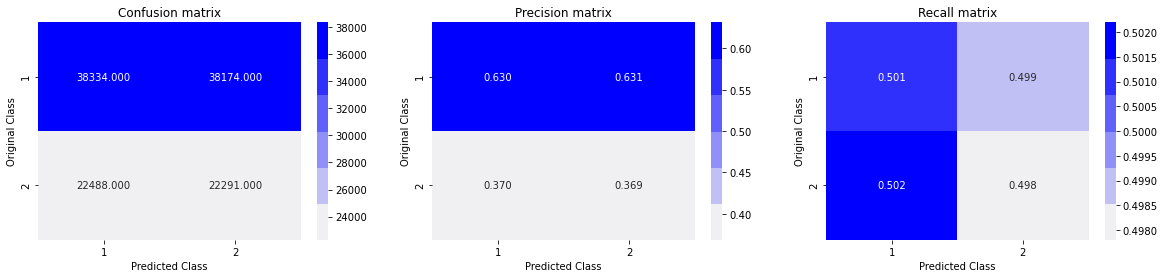

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.6585278256547589
For values of alpha =  0.0001 The log loss is: 0.6395921104554879
For values of alpha =  0.001 The log loss is: 0.627272865305169
For values of alpha =  0.01 The log loss is: 0.6280509742930812
For values of alpha =  0.1 The log loss is: 0.6040087615446673
For values of alpha =  1 The log loss is: 0.5044078660318663
For values of alpha =  10 The log loss is: 0.5262094346841774


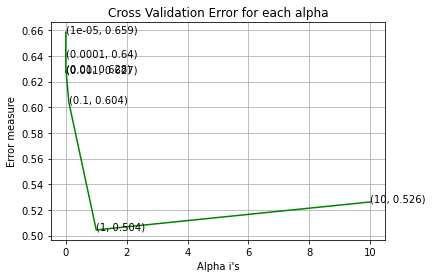

For values of best alpha =  1 The train log loss is: 0.5054060801221857
For values of best alpha =  1 The test log loss is: 0.5044078660318663
Total number of data points : 121287


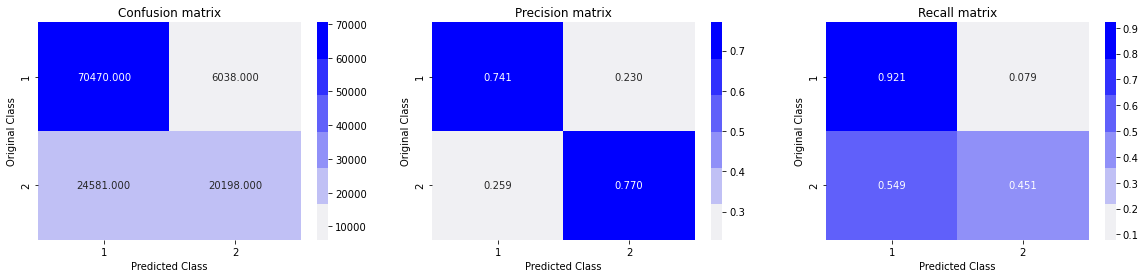

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning 

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge',max_iter=10,random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.6585278256547589
For values of alpha =  0.0001 The log loss is: 0.6585278256547589
For values of alpha =  0.001 The log loss is: 0.6585278256547589


# XGBoost 

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68483	valid-logloss:0.68488
[10]	train-logloss:0.61547	valid-logloss:0.61551
[20]	train-logloss:0.56479	valid-logloss:0.56488
[30]	train-logloss:0.52693	valid-logloss:0.52706
[40]	train-logloss:0.49768	valid-logloss:0.49773
[50]	train-logloss:0.47507	valid-logloss:0.47513
[60]	train-logloss:0.45718	valid-logloss:0.45718
[70]	train-logloss:0.44255	valid-logloss:0.44257
[80]	train-logloss:0.43080	valid-logloss:0.43084
[90]	train-logloss:0.42116	valid-logloss:0.42125
[100]	train-logloss:0.41340	valid-logloss:0.41348
[110]	train-logloss:0.40688	valid-logloss:0.40700
[120]	train-logloss:0.40130	valid-logloss:0.40145
[130]	train-logloss:0.39676	valid-logloss:0.39698
[140]	train-logloss:0.39305	valid-logloss:0.39327
[150]	train-logloss:0.38978	valid-logloss:0.39008
[160]	train-logloss:0.38696	valid-logloss:0.38730
[170]	train-logloss:0.38442	valid-logloss:0.38482
[180]	train-logloss:0.38212	valid-logloss:0.38263
[190]	train-logloss:0.38004	valid-logloss:0.38057
[200]	train

Total number of data points : 121287


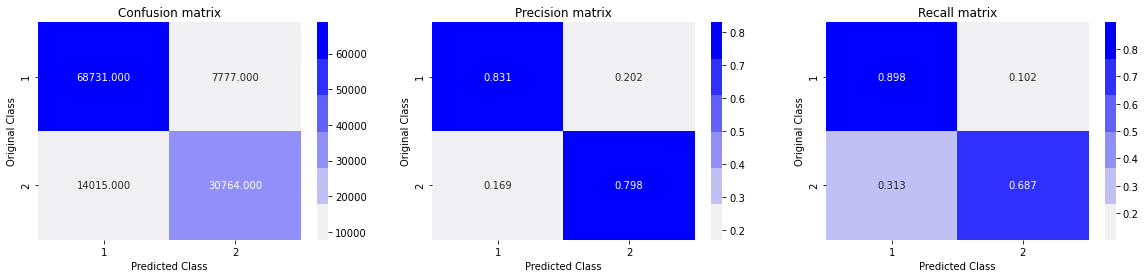

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)